# Exploring Dandiset 000617: Allen Institute Openscope - Sequence Learning Project

> **Note:** This notebook was generated with the assistance of AI. Please be cautious when interpreting the code or results, and verify important findings independently.

## Introduction

This notebook introduces Dandiset 000617, which contains data from the Allen Institute's Openscope Sequence Learning Project. The experiment investigates how neurons in the visual cortex of awake mice adapt to predictable sequences of visual stimuli.

**Link to Dandiset:** [Allen Institute Openscope - Sequence Learning Project](https://dandiarchive.org/dandiset/000617/0.250312.0130)

### What this notebook covers

1. Introduction to the Dandiset and its experimental design
2. Exploring the structure of the NWB files
3. Accessing and visualizing segmented cell information (ROIs)
4. Plotting calcium imaging ΔF/F traces for example cells
5. Examining stimulus presentation information
6. Demonstrating access to behavior and event detection data

### Required packages

The following Python packages are used in this notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# DANDI API and NWB access packages
from dandi.dandiapi import DandiAPIClient
import pynwb
import h5py
import remfile
from skimage.measure import find_contours

## Dandiset Overview

Let's use the DANDI Python API to access information about the Dandiset:

In [2]:
client = DandiAPIClient()
dandiset = client.get_dandiset("000617", "0.250312.0130")
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Dandiset version: {metadata['version']}")
print(f"License: {metadata['license']}")

Dandiset name: Allen Institute Openscope - Sequence Learning Project
Dandiset URL: https://dandiarchive.org/dandiset/000617/0.250312.0130
Dandiset version: 0.250312.0130
License: ['spdx:CC-BY-4.0']


### Key Dataset Features

This Dandiset contains experimental data from the Allen Institute's Sequence Learning Project, which investigates predictive computations in the neocortex of mice. Using two-photon calcium imaging, the team recorded neural responses as mice were presented with sequences of natural movie clips, aiming to understand how repeated exposure enables neural circuits to predict future sensory input based on past experience.

**Experimental Design:**
- Mice viewed repeating sequences of three different 2-second natural movie clips (labeled 'A', 'B', 'C'), interleaved with a grey screen ('X').
- Recordings span multiple sessions: pre-training (random order), training (sequence learning), and post-training.
- Calcium imaging data were recorded simultaneously from eight fields-of-view per session, covering layers 2/3 and 4 in visual cortical areas (V1, LM, AM, PM).
- The mouse line used expresses GCaMP6f in excitatory neurons.

## Exploring NWB Files

Let's explore the NWB files contained in the Dandiset:

In [3]:
from itertools import islice

# List the first 10 .nwb files to introduce structure
assets = dandiset.get_assets_by_glob("*.nwb")
example_files = list(islice(assets, 10))

print("Example NWB files in DANDI:000617 (first 10):\n")
print("| # | Path | Size (MB) |")
print("|---|------|-----------|")
for i, asset in enumerate(example_files):
    size_mb = asset.size / 1e6
    print(f"| {i+1} | {asset.path} | {size_mb:.1f} |")
print("\nEach file generally represents one session and field-of-view.")

Example NWB files in DANDI:000617 (first 10):

| # | Path | Size (MB) |
|---|------|-----------|
| 1 | sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb | 21166.3 |
| 2 | sub-684475/sub-684475_ses-1294084428-acq-1294179943-raw-movies_ophys.nwb | 21161.4 |
| 3 | sub-684475/sub-684475_ses-1293785946-acq-1293914859-raw-movies_ophys.nwb | 21174.8 |
| 4 | sub-684475/sub-684475_ses-1294084428-acq-1294179942-raw-movies_ophys.nwb | 21157.7 |
| 5 | sub-684475/sub-684475_ses-1294259213-acq-1294370666-raw-movies_ophys.nwb | 21179.6 |
| 6 | sub-684475/sub-684475_ses-1294259213-acq-1294370664-raw-movies_ophys.nwb | 21178.5 |
| 7 | sub-684475/sub-684475_ses-1293785946-acq-1293914856-raw-movies_ophys.nwb | 21203.0 |
| 8 | sub-684475/sub-684475_ses-1294259213-acq-1294370663-raw-movies_ophys.nwb | 21155.1 |
| 9 | sub-684475/sub-684475_ses-1293785946-acq-1293914853-raw-movies_ophys.nwb | 21160.0 |
| 10 | sub-684475/sub-684475_ses-1293785946-acq-1293914860-raw-movies_ophys.nwb | 21

The file naming convention follows BIDS format:

`sub-{subject_id}/sub-{subject_id}_ses-{session_id}-acq-{acquisition_id}-raw-movies_ophys.nwb`

Each NWB file contains data from one subject (mouse), session, and field-of-view (acquisition). The files are large (>20GB each) because they contain raw imaging data (movies).

## Examining an Example NWB File

Let's select one example NWB file to examine in detail:

In [4]:
# Select a representative file
asset_path = "sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb"

# Stream the remote file instead of downloading it
asset = next(dandiset.get_assets_by_glob(asset_path))
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Print basic file information
print(f"NWB File: {asset_path}")
print(f"Session description: {nwb.session_description}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Experiment description: {nwb.experiment_description}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Subject species: {nwb.subject.species}")
print(f"Subject genotype: {nwb.subject.genotype}")
print(f"Keywords: {list(nwb.keywords[:])}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


NWB File: sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb
Session description: Ophys Session
Session start time: 2023-08-31 20:49:56.751000+00:00
Experiment description: ophys session
Subject ID: 684475
Subject species: Mus musculus
Subject genotype: Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt
Keywords: ['2-photon', 'calcium imaging', 'visual cortex', 'behavior', 'task']


### NWB File Structure Overview

The NWB file contains:

1. **Acquisition Data:**
   - Raw two-photon imaging data (`raw_suite2p_motion_corrected`)
   - Eye tracking data (`EyeTracking`)
   - Running wheel signals (`v_in`, `v_sig`)

2. **Processed Data:**
   - Ophys processing module: fluorescence traces, segmentation, event detection
   - Running processing module: running speed and wheel movement
   - Stimulus timing information

3. **Intervals:**
   - Timing tables for stimulus presentations (gray, movie clips A/B/C)

4. **Metadata:**
   - Subject information, imaging parameters, experimental details

## Exploring Cell Segmentation (ROIs)

Let's examine the cell segmentation information to understand what cells were identified and where they're located in the field of view:

In [5]:
# Access the segmentation table
table = nwb.processing['ophys'].data_interfaces['image_segmentation'].plane_segmentations['cell_specimen_table']
cells_df = table.to_dataframe()
n_cells = cells_df.shape[0]

# Get imaging plane info
im_plane = table.imaging_plane

# Print summary information
print(f"Number of segmented ROIs/cells: {n_cells}\n")
print("Segmentation table columns:\n", list(cells_df.columns))
print("\nExample rows (first 5):")
print(cells_df[['cell_specimen_id', 'height', 'width', 'x', 'y', 'valid_roi']].head())

print("\nImaging plane info:")
print(f"  Description: {im_plane.description}")
print(f"  Location: {im_plane.location}")  
print(f"  Excitation Wavelength (nm): {im_plane.excitation_lambda}")
print(f"  Indicator: {im_plane.indicator}")
print(f"  Imaging Rate (Hz): {im_plane.imaging_rate}")

Number of segmented ROIs/cells: 18

Segmentation table columns:
 ['cell_specimen_id', 'height', 'mask_image_plane', 'max_correction_down', 'max_correction_left', 'max_correction_right', 'max_correction_up', 'valid_roi', 'width', 'x', 'y', 'image_mask']

Example rows (first 5):
            cell_specimen_id  height  width    x    y  valid_roi
id                                                              
1294200207                -1      18     19   60  470       True
1294200209                -1      22     20  217  442       True
1294200210                -1      17     22  298  477       True
1294200212                -1      15     16   46  379       True
1294200216                -1      17     26  108  366       True

Imaging plane info:
  Description: (512, 512) field of view in VISpm at depth 271 um
  Location: VISpm
  Excitation Wavelength (nm): 910.0
  Indicator: GCaMP6f
  Imaging Rate (Hz): 10.0


The segmentation table contains information about each ROI (Region of Interest), including:

- `cell_specimen_id`: Unique identifier for each cell
- `height`, `width`: Size of ROI in pixels
- `x`, `y`: Position of ROI in the imaging plane
- `image_mask`: 2D binary mask defining the ROI shape
- `valid_roi`: Whether the ROI was classified as a valid cell

## Visualizing Cell ROI Masks

Let's visualize the ROI masks overlaid on the mean projection image from the two-photon imaging:

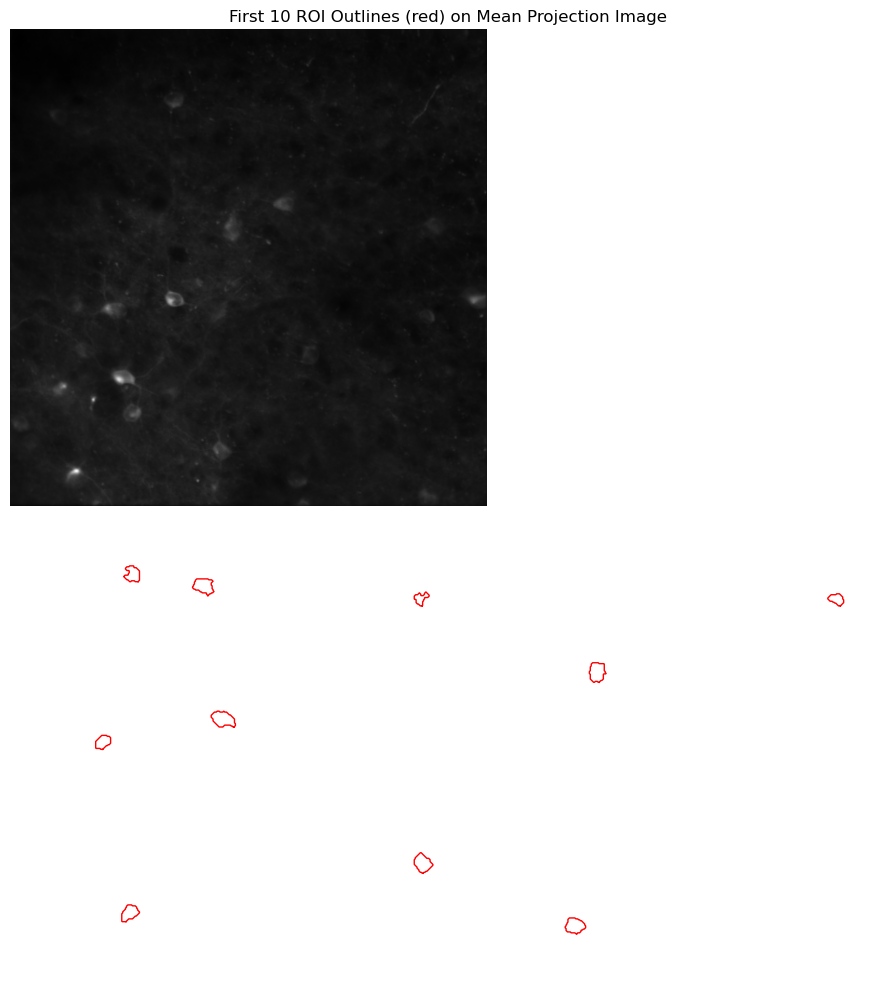

Note: There may be some spatial alignment discrepancies between the ROI outlines 
and the mean projection image due to image registration or field cropping.


In [6]:
# Get mean projection image for reference
processing = nwb.processing['ophys']
images = processing.data_interfaces['images']
avg_img = images.images['average_image'].data[:]

# Prepare to visualize ROI outlines using contours
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(avg_img, cmap='gray')

# Plot outlines of first 10 ROIs
for i, row in cells_df.head(10).iterrows():
    mask = np.array(row['image_mask'])
    y0, x0 = row['y'], row['x']  # mask anchor (upper-left corner)
    # Find contours of the mask and plot them
    contours = find_contours(mask.astype(float), 0.5)
    for contour in contours:
        # contour: [ [row, col], ... ] in local mask
        ax.plot(x0 + contour[:, 1], y0 + contour[:, 0], color='r', lw=1)

ax.set_title('First 10 ROI Outlines (red) on Mean Projection Image')
ax.axis('off')
plt.tight_layout()
plt.show()

print("Note: There may be some spatial alignment discrepancies between the ROI outlines \n"
      "and the mean projection image due to image registration or field cropping.")

> **Note:** Due to potential coordinate transformations during image registration, motion correction, or pre-processing, ROI contours may not perfectly align with cell bodies visible in the mean projection image. This is a common issue in calcium imaging datasets, and users should be aware of this when interpreting spatial relationships.

## Accessing Calcium Activity (ΔF/F) Traces

Now let's examine the calcium activity traces (ΔF/F) for several example cells:

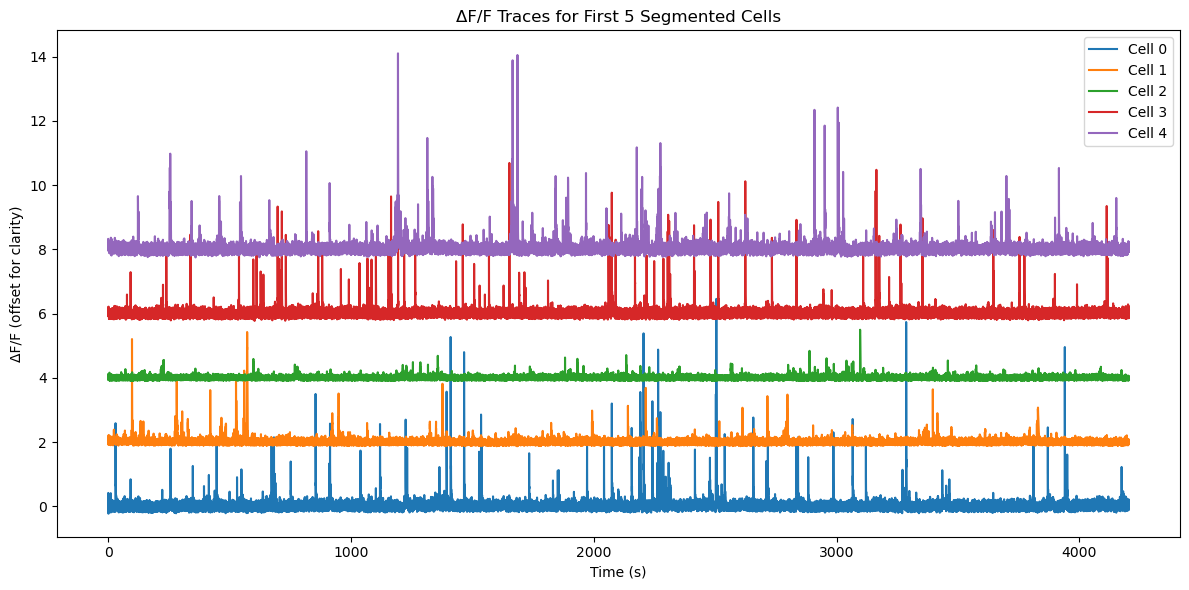

In [7]:
# Extract dF/F traces and timestamps
dff = nwb.processing['ophys'].data_interfaces['dff'].roi_response_series['traces']
dff_data = dff.data[:, :].T  # shape: n_cells x n_timepoints  
stamps = dff.timestamps[:]
t = stamps - stamps[0]  # start from 0 for nice plot axis

# Plot traces for the first 5 cells
n_plot = min(5, dff_data.shape[0])
plt.figure(figsize=(12, 6))
offset = 2  # vertical offset between traces
for i in range(n_plot):
    plt.plot(t, dff_data[i] + i*offset, label=f'Cell {i}')
plt.xlabel('Time (s)')
plt.ylabel('ΔF/F (offset for clarity)')
plt.title('ΔF/F Traces for First 5 Segmented Cells')
plt.legend()
plt.tight_layout()
plt.show()

The plot above shows the ΔF/F traces for the first 5 cells, with each trace vertically offset for clarity. The calcium signal represents neural activity - peaks in the signal typically correspond to bursts of action potentials or responses to stimuli.

Key observations:
- Sharp rises in ΔF/F indicate neural events (action potentials or bursts)
- Different cells show distinct activity patterns
- The imaging session is quite long (~4000 seconds) with many events

## Examining Stimulus Presentations

The experiment involves presenting different movie clips to the mouse. Let's examine the stimulus presentation structure:

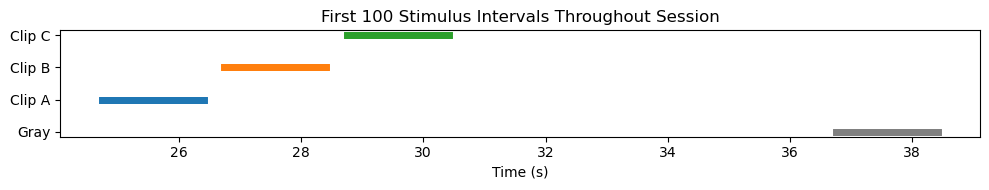

Total presentation counts for each stimulus:
  gray_presentations: 63000
  movie_clip_A_presentations: 63000
  movie_clip_B_presentations: 63000
  movie_clip_C_presentations: 63000


In [8]:
# Get stimulus interval information
stim_names = ['gray_presentations', 'movie_clip_A_presentations', 
              'movie_clip_B_presentations', 'movie_clip_C_presentations']
colors = ['gray', 'tab:blue', 'tab:orange', 'tab:green']

# Plot presentation times for a subset of presentations
fig, ax = plt.subplots(figsize=(10, 2))
yoff = 0

# Plot the first 100 presentations of each stimulus type
for stim_name, color in zip(stim_names, colors):
    tbl = nwb.intervals[stim_name]
    n_plot = min(len(tbl), 100)  # Only plot first 100 intervals
    starts = tbl['start_time'].data[:n_plot]
    stops = tbl['stop_time'].data[:n_plot]
    for s, e in zip(starts, stops):
        ax.plot([s, e], [yoff, yoff], color=color, lw=5)
    yoff += 1

ax.set_yticks(range(len(stim_names)))
ax.set_yticklabels(['Gray', 'Clip A', 'Clip B', 'Clip C'])
ax.set_xlabel('Time (s)')
ax.set_title('First 100 Stimulus Intervals Throughout Session')
plt.tight_layout()
plt.show()

# Display total presentation counts
tbl_summary = {name: len(nwb.intervals[name]) for name in stim_names}
print('Total presentation counts for each stimulus:')
for name, count in tbl_summary.items():
    print(f"  {name}: {count}")

This visualization shows the timing of stimulus presentations during the session. Each horizontal bar represents when a particular stimulus (Gray, Clip A, B, or C) was shown to the mouse.

The large number of presentations (63,000 for each type) indicates extensive stimulus repetition, which is crucial for studying sequence learning and neural adaptation.

## Accessing Behavioral and Event Detection Data

### 1. Running Speed Information

The dataset includes behavioral measurements like running speed. Here's how to access it:

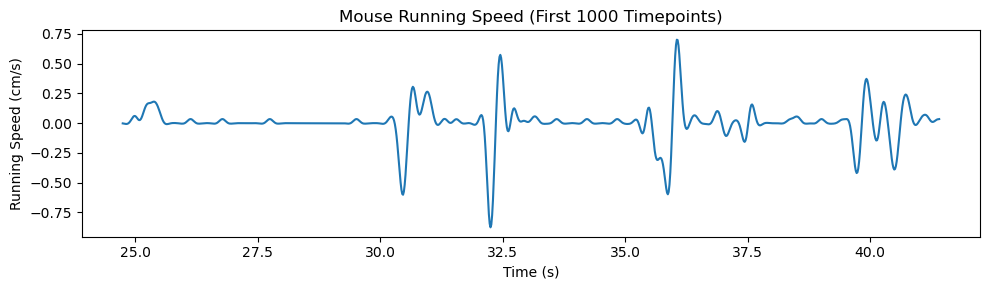

In [9]:
# Access running speed data
speed = nwb.processing['running'].data_interfaces['speed']
time = speed.timestamps[:1000]  # First 1000 timepoints for quick plotting
speed_cm_per_s = speed.data[:1000]

plt.figure(figsize=(10, 3))
plt.plot(time, speed_cm_per_s)
plt.xlabel('Time (s)')
plt.ylabel('Running Speed (cm/s)')
plt.title('Mouse Running Speed (First 1000 Timepoints)')
plt.tight_layout()
plt.show()

### 2. Event Detection Data

The dataset also includes event detection data, which represents inferred neural events from the calcium traces:

Event detection parameters:
  Lambda values (first 5 cells): [0.0287 0.0128 0.0086 0.0289 0.0335]
  Noise standard deviations (first 5 cells): [0.06418523 0.04296032 0.03497644 0.06435245 0.06978224]


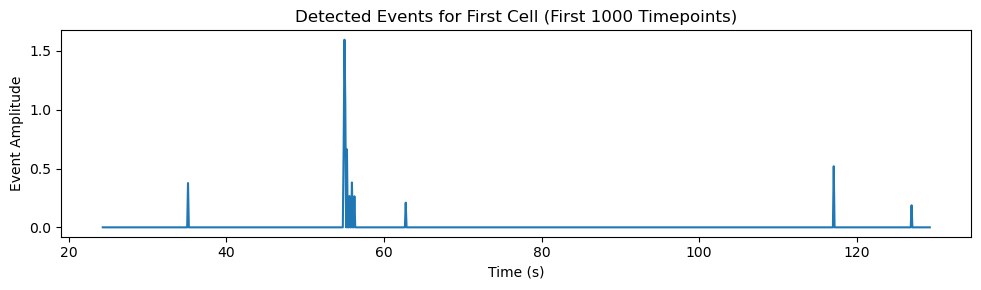

In [10]:
# Access event detection data
event_det = nwb.processing['ophys'].data_interfaces['event_detection']
event_data = event_det.data[:1000, :5]  # First 1000 timepoints, first 5 cells
event_time = event_det.timestamps[:1000]

# Get some statistics about the events
lambdas = event_det.lambdas[:]
noise_stds = event_det.noise_stds[:]

print("Event detection parameters:")
print(f"  Lambda values (first 5 cells): {lambdas[:5]}")
print(f"  Noise standard deviations (first 5 cells): {noise_stds[:5]}")

# Plot event data for the first cell
plt.figure(figsize=(10, 3))
plt.plot(event_time, event_data[:, 0])
plt.xlabel('Time (s)')
plt.ylabel('Event Amplitude')
plt.title('Detected Events for First Cell (First 1000 Timepoints)')
plt.tight_layout()
plt.show()

## Summary and Next Steps

In this notebook, we've explored the Allen Institute Openscope Sequence Learning Project dataset (Dandiset 000617). We've seen how to:

1. Access metadata and NWB files from the DANDI archive
2. Examine the structure of NWB files including cell segmentation, calcium imaging, and stimulus presentation
3. Visualize ROI masks, calcium traces, and stimulus timing
4. Access behavioral and event detection data

### Possible Next Steps for Analysis

- Align calcium activity to stimulus onsets to examine stimulus-evoked responses
- Compare neural responses between different movie clips
- Analyze how responses change with repeated stimulus presentations (sequence learning)
- Correlate neural activity with running behavior
- Perform population analyses across multiple cells